<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| [Emmanuel Rachelson](https://personnel.isae-supaero.fr/emmanuel-rachelson?lang=en) and [Dennis G. Wilson](https://personnel.isae-supaero.fr/dennis-wilson) | <a href="https://supaerodatascience.github.io/deep-learning/">https://supaerodatascience.github.io/deep-learning/</a>

<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;"> Deep Learning</div>

This class supposes a basic knowledge of Artificial Neural Networks, Backpropagation and Stochastic Gradient Descent (as introduced in the previous class). If you want an in-depth refresher on linear algebra specific to deep learning, [these notebooks](https://github.com/hadrienj/deepLearningBook-Notes) are well-done.

0. [Preparation](#sec0)
1. [Dataset: Fashion-MNIST](#sec1)
2. [ANNs in Layers](#sec2)
3. [Backpropagation and training](#sec3)
4. [Activation Functions](#sec4)
5. [Convolutional Neural Networks](#sec5)
6. [Overfitting](#sec6)
7. [Improving Optimization](#sec7)


# <a id="sec0">0. Preparation</a>

In this notebook, we'll be using `torch`, `torchvision`, and `ignite`. Please refer to the [PyTorch](https://pytorch.org/get-started/locally/) website for installation instructions. We'll also be using the packages `sklearn`, `numpy`, and `matplotlib`. To make the notebook into slides, I'm using [`rise`](https://github.com/damianavila/RISE) which you can also install. Note that this notebook is fairly compute intensive and might be better [run in Google Colab.](https://colab.research.google.com/github/SupaeroDataScience/deep-learning/blob/main/deep/Deep%20Learning.ipynb)

<div class="alert alert-success">
Exercise 1:
Install the necessary packages and verify that everything is working by importing everything.
</div>

In [ ]:
# !pip install torch torchvision pytorch-ignite

In [1]:
import torch
import torchvision
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# <a id="sec1">1. Dataset: Fashion-MNIST</a>

<div class = "alert alert-warning">

Au lieu de classifier des chiffres manuscrit, on classifie des images 28x28 de vêtements issues de Zalando
- benchmark connu de diffculté moyenne 
- moins 99.9% d'accuracy sur Fashion MNIST = pas la peine de présenter le nouvel algo

[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Fashion-MNIST is a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits but is more complex.

<img src="img/fashion-mnist-small.png">

In [2]:
labels_text = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

PyTorch comes with this dataset by default, but we need to download it. We'll then make dataloaders which lazily iterate through the datasets. We'll use a training set and a validation set and greatly reduce their sizes to make this notebook run in a reasonable time.

In [3]:
import torchvision.transforms as transforms

# On normalise les images en un ensemble de pixels (nv de gris) de moyenne nulle et écart type 0.5
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# On stock ces données sous le répertoire data
full_trainset = torchvision.datasets.FashionMNIST(root='../data', train=True, download=True, transform=transform)

# On sépare en deux groupes : un training set de 10 000, un set de validation de 50 000
trainset, full_validset = torch.utils.data.random_split(full_trainset, (10000, 50000))
# Parmi les 50 000 qu'on peut utiliser pour valider, on utilise que 1000 des 50 000 images de validation possibles
validset, _ = torch.utils.data.random_split(full_validset, (1000, 49000))

# trainloader charge des batchs de 4, num_worker : nb de threads de calcul
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=4, shuffle=False, num_workers=2)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



The test data should also be downloaded. We'll use it at the very end of this notebook to test our model.

In [4]:
testset = torchvision.datasets.FashionMNIST(root='../data', train=False, download=True, transform=transform)

<div class="alert alert-success">
Exercise 2:
Download the Fashion-MNIST dataset and run the following code.
    
+ Why are there 4 images in our list?
+ Why does the list of images change every time we run the code?

</div>

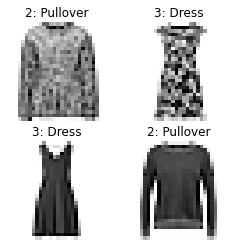

In [9]:
# get the first batch of images and labels
dataiter = iter(trainloader)
images, labels = dataiter.next()

plt.figure(figsize=(4,4))
for i in range(len(images)):
    l = labels[i].numpy()
    plt.subplot(2, 2, i+1)
    plt.title('%d: %s' % (l, labels_text[l]))
    plt.imshow(images[i].numpy()[0], cmap='Greys')
    plt.axis('off')

<div class = "alert alert-warning">

Le résultat change à chaque fois qu'on relance le code parce qu'on itère sur les batch : on passe au batch suivant à chaque fois au'on relance ce code

For the rest of today, we'll focus on creating a deep neural network that accurately classifies these images. This will highlight one application of deep learning, image processing, which has been highly successful. In upcoming classes, we'll see other examples of deep learning (GANs, LSTMs) which have different architectures and training rules. However, the basic principles remain the same!

# <a id="sec2">2. ANNs in Layers</a>

Last class, we looked at individual neurons organized in networks like this:

<img src="img/nn_fc.png" width="60%">

These two hidden layers are called "Fully Connected layers" because every neuron of these layers is connected to every neuron of the previous layer.

In PyTorch, Fully Connected layers are represented with the `torch.nn.Linear` function. The documentation is [here](https://pytorch.org/docs/stable/nn.html?highlight=torch%20nn%20linear#torch.nn.Linear) or we can ask Jupyter:

In [10]:
help(torch.nn.Linear)

Help on class Linear in module torch.nn.modules.linear:

class Linear(torch.nn.modules.module.Module)
 |  Linear(in_features: int, out_features: int, bias: bool = True, device=None, dtype=None) -> None
 |  
 |  Applies a linear transformation to the incoming data: :math:`y = xA^T + b`
 |  
 |  This module supports :ref:`TensorFloat32<tf32_on_ampere>`.
 |  
 |  Args:
 |      in_features: size of each input sample
 |      out_features: size of each output sample
 |      bias: If set to ``False``, the layer will not learn an additive bias.
 |          Default: ``True``
 |  
 |  Shape:
 |      - Input: :math:`(*, H_{in})` where :math:`*` means any number of
 |        dimensions including none and :math:`H_{in} = \text{in\_features}`.
 |      - Output: :math:`(*, H_{out})` where all but the last dimension
 |        are the same shape as the input and :math:`H_{out} = \text{out\_features}`.
 |  
 |  Attributes:
 |      weight: the learnable weights of the module of shape
 |          :math:`(

Let's make a single fully connected layer:

In [13]:
from torch import nn

# 784 neurones en entrée (images de 28x28)
# 10 neurones en sortie (10 catégories en sortie)
# nn.linear initialise automatiquement les poids initiaux avec tirage aléatoire selon une gaussienne
fc = nn.Linear(784, 10)

Let's use this layer as a network and construct a forward pass function. Our image data is 28 by 28, but we want it to match the layer dimensions. We'll transform the image from 28 by 28 to 1 by 784, and then pass the image through our fully connected layer.

In [15]:
def forward(x): # x est 28x28, on peut le transformer en 1x784
    x = x.view(-1, 28 * 28) # Transforms from (1, 28, 28) to (1, 784)
    x = fc(x) # Goes through fully connected layer
    return x # Output, 10 neurons

We'll take the maximum output as our label prediction. Let's see how this layer does - remember we haven't trained it, it's completely random.

In [16]:
# La prédiction finale = neurone de sortie avec la plus grande valeur 
for batch in range(3):
    images, labels = dataiter.next()
    for i in range(len(images)):
        outputs = forward(images[i])
        h = np.argmax(outputs.detach().numpy())
        y = labels[i]
        print('True: %d %s, Predicted: %d %s' % (y, labels_text[y], h, labels_text[h]))

True: 0 T-shirt/top, Predicted: 6 Shirt
True: 5 Sandal, Predicted: 6 Shirt
True: 5 Sandal, Predicted: 2 Pullover
True: 1 Trouser, Predicted: 1 Trouser
True: 7 Sneaker, Predicted: 2 Pullover
True: 0 T-shirt/top, Predicted: 1 Trouser
True: 8 Bag, Predicted: 2 Pullover
True: 5 Sandal, Predicted: 6 Shirt
True: 2 Pullover, Predicted: 2 Pullover
True: 6 Shirt, Predicted: 1 Trouser
True: 8 Bag, Predicted: 2 Pullover
True: 0 T-shirt/top, Predicted: 1 Trouser


<div class = "alert alert-warning">

Le résultat est très mauvais : on n'a fait que mettre des poids aléatoires sur le réseau de neurone.
    
Il n'y a pas encore eu d'apprentissage donc c'est normal que les prédiction ne correspondent pas aux labels réels pour le moment.
    
Après apprentissage, on veut que la valeur de sortie des neurone correspond à la distribution de probabilité (proba d'une image d'être de chacune des catégories)

Let's double check that our fully connected layer is simply doing $$y = w^T x + b$$

In [17]:
a = (np.matmul(images[1].view(-1, 784), np.transpose(fc.weight.detach().numpy())) + fc.bias)[0].detach().numpy()
b = forward(images[1]).detach().numpy()
print('Numpy:\n', a)
print('PyTorch:\n', b)

Numpy:
 [-0.9155461   0.4701897   0.08783763  0.04759891 -0.43324316  0.16275181
  0.4521196  -0.7318341  -1.1817149  -0.0889522 ]
PyTorch:
 [[-0.9155461   0.4701897   0.08783763  0.04759891 -0.43324316  0.16275181
   0.4521196  -0.7318341  -1.1817149  -0.0889522 ]]


<div class = "alert alert-warning">

On a bien fait le calcul $y = w^T x + b$ avec la fonction forward avec cette fonction pytorch

In [18]:
print(a == b, 'difference: ', np.sum((a-b)**2))

[[ True  True  True  True  True  True  True  True  True  True]] difference:  0.0


We have some slight errors due to floating point representation differences between PyTorch and numpy, but the calculation is the same!

In [29]:
def forward(x):
    x = x.view(-1, 28 * 28)
    x = nn.Linear(784,10)(x) # on crée des couches avec des poids aléatoires
    return x

for i in range(len(images)):
    outputs = forward(images[i])
    h = np.argmax(outputs.detach().numpy())
    y = labels[i]
    print('True: %d %s, Predicted: %d %s' % (y, labels_text[y], h, labels_text[h]))

True: 2 Pullover, Predicted: 9 Ankle boot
True: 6 Shirt, Predicted: 0 T-shirt/top
True: 8 Bag, Predicted: 6 Shirt
True: 0 T-shirt/top, Predicted: 1 Trouser


<div class="alert alert-success">
Exercise 3:
    
1. The following code produces different predictions every time. Why? Change it so that it always predicts the same response.
2. Change the forward pass function to a network with the following fully connected layers: (784, 128), (128, 10). Test this network with random weights on some images.
    
</div>

<div class = "alert alert-warning">
A chaque forward, on tirait une couche aléatoirement : il faut créer deux couches fc1 et fc2 qui ne sont pas réinitialisé à chaque appel de forward

In [24]:
# %load solutions/ex3_1.py
fc1 = nn.Linear(784, 128)
fc2 = nn.Linear(128, 10)

In [28]:
# %load solutions/ex3_2.py
def forward(x):
    x = x.view(-1, 28 * 28)
    x = fc1(x)
    x = fc2(x)
    return x

for i in range(len(images)):
    outputs = forward(images[i])
    h = np.argmax(outputs.detach().numpy())
    y = labels[i]
    print('True: %d %s, Predicted: %d %s' % (y, labels_text[y], h, labels_text[h]))


True: 2 Pullover, Predicted: 4 Coat
True: 6 Shirt, Predicted: 4 Coat
True: 8 Bag, Predicted: 4 Coat
True: 0 T-shirt/top, Predicted: 5 Sandal


We'll formalize our neural network functions in a `torch.nn.Module` class which creates the layers when initialized and then calculates the forward pass of the network with the function `forward(x)`.

In [30]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(784, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
net = SimpleNet()

Now that we have our network, we're ready to train it.

# <a id="sec3">3. Backpropagation and training</a>

So far, the way we've been using `torch` has been almost equivalent to `numpy`, and we've been calling `detach().numpy()` on `torch` objects to convert them to numpy arrays. We haven't yet taken advantage of the main benefit of `torch`: automatic differentiation. Let's look at that and see how it helps us train our neural network.

<div class = "alert alert-warning">

**Objet de base de torch = tenseur** (généralisation multidimensionnelle d'un vecteur/matrice
- scalaire : tenseur de dimension 0
- vecteur : tenseur de dimension 1
- matrice : tenseur de dimension 2
- tenseur -> on peu aller à n'importe quelle dimension

PyTorch fait des opérations sur les tenseurs sous forme de graph de calculs et calcul les gradients (différentiation automatique)

First, a bit of vocabulary. The objects we're working with, neural network weights and biases, are called `tensors`. 
<img src="img/tensor.png" width="50%">
A `tensor` is a generic term for a linear mapping of any linear mapping from one algeabraic object to another. A scalar is a single value, a vector a 1D object of values, a matrix a 2D object, and a tensor is an N-dimension object (scalars, vectors, and matrices are also tensors). In deep learning frameworks, tensors are the core computational object. We store all values in tensors and link them in computational graphs.

A torch tensor looks very much like a numpy object. We can compare a 2D torch tensor and a numpy matrix:

In [33]:
a = np.ones((2, 2))
b = torch.ones(2, 2)
print('Numpy: \n', a)
print('Torch: \n', b)
np.all(b.numpy() == a)

Numpy: 
 [[1. 1.]
 [1. 1.]]
Torch: 
 tensor([[1., 1.],
        [1., 1.]])


True

However, we can ask torch to keep track of the gradient of a tensor. As this tensor is used to compute other tensors, this will create a computational graph.

In [35]:
#ce tenseur sera utilisé dans un graph de calcul dans lequel on calculera les gradients 
x = torch.ones(2, 2, requires_grad=True) 
print('x: ', x)
y = (3 * x * x).mean() #valeur en sortie 
print('y: ', y)
y.backward() #backprop pour calculer dy/dx (les poids) (niveau n+1 p/r au niveau n)
print('dy/dx: ', x.grad)

x:  tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
y:  tensor(3., grad_fn=<MeanBackward0>)
dy/dx:  tensor([[1.5000, 1.5000],
        [1.5000, 1.5000]])


The gradient definition in `y` depends on the calculation of `x` and allows us to calculate `dy/dx` by calling `backward()`. This is known as automatic differentiation, as the gradients at each step in the computation are automatically calculated. If you want to go further in detail about this, check out the [autograd tutorial](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html).

Let's use automatic differentiation to calculate the gradients of our neural network parameters. This will automatically perform backpropogation using the gradient definition at each function in our network.

In [36]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
# transforme des classes catégorielles avec des 0 partout sauf un endroit où on a 1
onehot = torch.nn.functional.one_hot(labels, num_classes=10).float()

labels, onehot

(tensor([7, 7, 1, 3]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]]))

`images` contains our batch of input, so calling `net` on it will perform a forward pass through the network. We'll then compare this to the onehot encoded label and compute the Mean Squared Error.

In [42]:
net = SimpleNet()
outputs = net(images)
print('Outputs ', outputs)
# On a 4 lignes : les 4 images du minibatch
# On a 10 colonne : "la probabilité" que l'élément appartienne à chacune des classes 

loss = torch.sum((outputs - onehot) ** 2, 1).mean()
print('Loss ', loss)

Outputs  tensor([[-0.2836,  0.0490,  0.4045,  0.0847,  0.1028,  0.1669, -0.0784, -0.3126,
         -0.1658, -0.2588],
        [-0.0948,  0.0281,  0.3575,  0.2845,  0.1034,  0.0747,  0.1018, -0.0008,
         -0.1024, -0.1855],
        [-0.2780,  0.0453, -0.0973, -0.1959, -0.3298,  0.0635, -0.0544, -0.3150,
          0.2560, -0.1058],
        [-0.3746, -0.0437,  0.0713,  0.0286, -0.0603, -0.0346, -0.2193, -0.3510,
          0.2955, -0.1061]], grad_fn=<AddmmBackward0>)
Loss  tensor(1.5253, grad_fn=<MeanBackward0>)


Now that we've calculated the error, we can backpropagate it using `backward()`. We first set all the gradients to zero, and then we'll observe how the gradients of the second layer's bias change.

In [43]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('fc2.bias.grad before backward')
print(net.fc2.bias.grad)

loss.backward()

print('fc2.bias.grad after backward')
print(net.fc2.bias.grad)

fc2.bias.grad before backward
None
fc2.bias.grad after backward
tensor([-0.5155, -0.4606,  0.3680, -0.3990, -0.0920,  0.1352, -0.1252, -1.4897,
         0.1416, -0.3281])


We can use this gradient calculation to update the neural network weights:
$$w_{ij} \leftarrow w_{ij} - \alpha \left(f_\theta(x) - y\right) \delta_j x_{ij}$$

In [45]:
print('fc2.bias before training : ')
print(net.fc2.bias.data)

learning_rate = 0.01 #alpha
for f in net.parameters(): #les paramètres de la couche
    f.data.sub_(f.grad.data * learning_rate)

print('fc2.bias after training : ')
print(net.fc2.bias.data)

fc2.bias before training : 
tensor([ 0.0334,  0.0874, -0.0077,  0.0286, -0.0645, -0.0022,  0.0842, -0.0179,
         0.0192, -0.0724])
fc2.bias after training : 
tensor([ 0.0386,  0.0920, -0.0113,  0.0326, -0.0636, -0.0035,  0.0855, -0.0030,
         0.0178, -0.0691])


Torch provides loss functions and optimizers that we can use instead of writing our own. For now, we'll use the `torch.nn.CrossEntropyLoss` and `torch.optim.SGD` functions.

Just one last thing before we train on the full dataset: we're calculting the gradients at every batch, not at every data point. This is an expensive gradient calculation, so let's reduce the number of times we do it by increasing the batch size. This has the benefit of reducing overfitting by computing the gradient over a large sample of images.

<div class = "alert alert-warning">
Optimiseur et loss (ex : MSE) déjà existants dans pytorch (pas besoin de le réécrire) 

In [47]:
# On fait une époque : un passage sur les 10 000 données d'entraînement avec des batchs de 512
def train(net):
    #on fait des batchs de 512
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=2) 
    
    #représente la distance entre notre prédiction est la catégorie réelle 
    criterion = nn.CrossEntropyLoss() 
    
    #optimiseur : stochastic gradient descent pour optimiser les poids et biais
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 
    
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0): # i le numéro du batch, data le batch étudié
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step() # applique les poids 
        train_loss += loss.item()
    return train_loss

In [49]:
net = SimpleNet()

# temps pour faire une époque
%time train_loss = train(net)
print(train_loss)

CPU times: user 346 ms, sys: 65.1 ms, total: 411 ms
Wall time: 1.3 s
44.08357238769531


To see how our network performs, we'll apply it to the validation set.

In [50]:
def get_valid_predictions(net):
    validloader = torch.utils.data.DataLoader(validset, batch_size=4, shuffle=False)
    all_labels = np.array([])
    predictions = np.array([])
    
    # on ne fait que valider ici donc pas de backprop que des forward path
    with torch.no_grad():  
        for data in validloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels = np.append(all_labels, labels.numpy())
            predictions = np.append(predictions, predicted.numpy())
            
    return all_labels, predictions

In [51]:
y_valid, predictions = get_valid_predictions(net)

In [52]:
from sklearn.metrics import accuracy_score, classification_report

print('Accuracy: ', accuracy_score(predictions, y_valid))
print(classification_report(predictions, y_valid, target_names=labels_text))

Accuracy:  0.437
              precision    recall  f1-score   support

 T-shirt/top       0.00      0.00      0.00         1
     Trouser       0.93      0.55      0.69       182
    Pullover       0.00      0.00      0.00         0
       Dress       0.49      0.45      0.47       135
        Coat       0.62      0.33      0.43       177
      Sandal       0.40      0.20      0.26       179
       Shirt       0.15      0.21      0.18        70
     Sneaker       0.89      0.54      0.67       171
         Bag       0.08      1.00      0.15         8
  Ankle boot       0.72      0.88      0.79        77

    accuracy                           0.44      1000
   macro avg       0.43      0.42      0.36      1000
weighted avg       0.64      0.44      0.50      1000



/home/ymycandy/anaconda3/envs/pyseminar/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ymycandy/anaconda3/envs/pyseminar/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ymycandy/anaconda3/envs/pyseminar/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<div class = "alert alert-warning">

Un classifieur aléatoire ferait autour de 10% d'accuracy
ici on a 44% avec une seule époque donc c'est déjà pas mal
On pourrait en faire plus pour une meilleure accuracy
    
- pour le moment, on n'a fait que des couches linéaires
- on pourrait faire des sigmoïdes pour faire des règles de décisions qui ne sont pas que des séparateurs linéaires

# <a id="sec4">4. Activation Functions</a>

So far, our network is a chain of $$ Y = w^T x+b $$ However, in the last class, the neurons we modeled used sigmoid functions: $$ Y = \sigma(w^T x+b) $$ Let's apply this to our current network and see how it changes training. Torch has two ways to do this: define a `torch.nn.Sigmoid` layer or apply the `torch.sigmoid` function. We'll use the functional method.

In [53]:
class SigmoidNet(nn.Module):
    def __init__(self):
        super(SigmoidNet, self).__init__()
        self.fc1 = nn.Linear(784, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = torch.sigmoid(self.fc1(x)) #on fait passer la combinaison linéaire par la sigmoïde pour calculer la sortie de la couche
        x = torch.sigmoid(self.fc2(x)) #on fait une sigmoide sur la couche de sortie pour avoir des probabilités d'appartenance à une catégorie
        return x

net = SigmoidNet()

In [54]:
total_loss = train(net) #train ne change pas : il y a juste la fonction utilisée pour les forward_pass qui changent en sigmoïdes
y_valid, predictions = get_valid_predictions(net)
print('Accuracy: ', accuracy_score(predictions, y_valid))

Accuracy:  0.088


<div class = "alert alert-warning">

Bof : 
- on fait une optimisation par descente de gradient sur une fonction loss qui est défini sur l'ensemble des paramètres du réseau de neurone (ici, on a de l'ordre de 784x120x10 paramètres)
    - il se peut qu'il y ait des minima locaux, dans lesquels on peut être coincé
    - pas robuste pour ce qui est de l'optimisation de la loss... On ne trouve pas nécessairement un minimum correct
    - mais, on peut facilement passer à l'échelle (on ne peut pas calculer dans de grandes dimensions comme ça avec n'importe quelle méthode d'optimisations) 
    - C'est le prix à payer pour pouvoir utiliser des réseaux de neurone profond (avec bcp de couches pour bien modéliser -> bcp de paramètres -> grande dimension)

## Rectified Linear Units (ReLU)

We'll now look at a different activation function, the ReLU. Remember the shape of the sigmoid activation function?

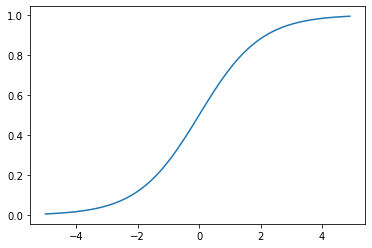

In [55]:
def sigmoid(x):
    return 1./(1. + np.exp(-x))

XX = np.arange(-5,5.,0.1)
plt.plot(XX,sigmoid(XX));

Let's plot the gradient of this function.

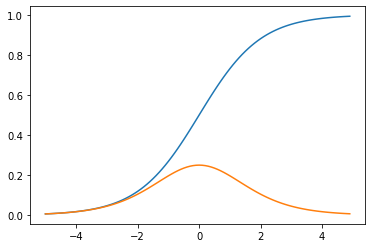

In [56]:
def sigmoid_der(x):
    y = sigmoid(x)
    return y*(1.-y)

XX = np.arange(-5,5.,0.1)
plt.plot(XX,sigmoid(XX));
plt.plot(XX,sigmoid_der(XX));

<div class = "alert alert-warning">

Problème de la sigmoïde : le gradient est petit (compris entre 0 et 0.3) **problème d'evanescence du gradient**
- donc quand on fait $\delta_j = \sigma'(y_j) \sum_{l\in L_j} \delta_l w_{jl}$, on écrase nécessairement l'amplitude des gradients lors de la backpropagation
- gradients petits -> l'amplitude de mise à jour des poids petits -> mise à jour pas très efficace
- solution : **Rectified Linear Unit (ReLU)** au lieu de la sigmoïde
    - le gradient vaut alors 1 ou 0 
    - soit il écrase le gradient à 0, soit il n'écrase pas du tout le gradient avec 1

Do you remember that during backpropagation, the $\delta_j$ were recursively obtained by:
$$\delta_j = \sigma'(y_j) \sum_{l\in L_j} \delta_l w_{jl}$$

This poses a major problem when the networks become deeper: at each layer, we multiply our gradients by $\sigma'(y_j)$ which is much smaller than 1. So the gradient we want to back-propagate shrinks to zero and all our weight updates become zero.

This is called the **vanishing gradient** problem.

To avoid this problem, we introduce a new type of activation function: the Rectified Linear Unit (ReLU).
$$\sigma(y) = \max\{0,y\}$$

The key property of this function is that its derivative is either zero or one.

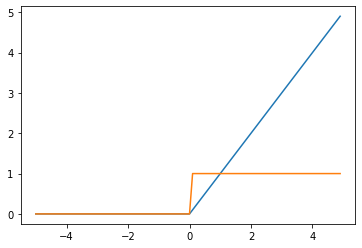

In [57]:
def relu(x):
    return np.maximum(0.,x)
def relu_der(x):
    return relu(x) > 0

plt.plot(XX,relu(XX));
plt.plot(XX,relu_der(XX));

**Caveat of using ReLU activation functions**

Although they allow us to train deep networks, ReLU functions have their downsides.
- Unbounded values: the output of a layer is not bounded anymore, causing possible divergence.
- Dying ReLU neurons: the backpropagation of gradients can push the input weigths towards values such that $\sigma(y)=0$ all the time. Then all future backpropagations will leave these weights unchanged: the neuron is dead.

Some advanced methods can compensate these weaknesses but are out of the scope of this introduction.

In torch, the ReLU activation function is either a layer `torch.nn.ReLU` or a function in `torch.nn.functional.relu`.

<div class = "alert alert-warning">

Ok, l'utilisation de la ReLU permet d'éviter l'evanescence du gradient

Problème de l'utilisation de la ReLU : cette fonction d'activation n'est pas bornée!!! 
- cela ne permet pas de satisfaire les conditions du théo d'approx universelle
- on n'a pas de borne sur la valeur de sortie de la ReLU... 
    - avant, avec la sigmoïde, on avait une valeur bornée entre 0 et 1 peu importe la velru en entrée
- on prie pour que ça se passe bien...

<div class="alert alert-success">
Exercise 5: Change the activation functions in your network. Experiment with different layer sizes and activations to get a higher accuracy.
</div>

In [61]:
# %load solutions/ex5.py
import torch.nn.functional as F

class ReLUNet(nn.Module):
    def __init__(self):
        super(ReLUNet, self).__init__()
        self.fc1 = nn.Linear(784, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # on pourrait aussi mettre une sigmoïde : pour ramener à une valeur entre 0 et 1
        return x

net = ReLUNet()
train(net)
y_valid, predictions = get_valid_predictions(net)
print('Accuracy: ', accuracy_score(predictions, y_valid))


Accuracy:  0.36


<div class = "alert alert-warning">

Globalement, ici, on a modélisé le comportement sur une fonction linéaire par morceaux (ici on a 120 morceaux)

On a besoin de ReLU pour éviter l'evanescence du gradient quand on a un réseau réellement profond (avec beaucoup plus de couches cachées qu'ici par exemple)

# <a id="sec5">5. Convolutional Neural Networks</a>

<div class = "alert alert-warning">

Jusqu'ici, on a mis l'image à plat... c'est dommage on perd l'info de proximité des pixels...
- pour cela il faut construire des opérateurs (couches) qui peuvent opérer directement sur les images au lieu de travailler sur les images mises à plat : **réseaux convolutionnels**
    - détecter un chat en haut à gauche de l'image = pareil que d'en détecter un en bas à droite
    - on apprend un filtre de convolution : les poids sont les mêmes d'une sous-zone à une autre
    - cela fait qu'on a beaucoup moins de poids à optimiser qu'avant et permet de faire des opérations similaires dans des localités différentes
       - on ballade le filtre (cube blanc) le long de l'image -> à chaque position on obtient en sortie un scalaire
            - on optimise la valeur des paramètres sur ce filtre
       - cela construit une nouvelle image de l'image initiale 

The main factor which makes deep learning so useful for computer vision is the use of convolutions. Convolutional networks exploit the fact that the data is actually an image in the learning while decreasing the number of weights in the network. To do this, they define **convolution filters** that brush across the image. Such a filter defines a so-called **feature map** that shares the weights of the filter. The result of applying a feature map on an image is a new image of lower resolution, where each pixel is the result of the convolution of the filter with a set of pixels from the input image, as illustrated on the figure below. The Stanford class [CS231n](http://cs231n.github.io/convolutional-networks/) also has an excellent demo.

<img src="img/convnet.gif" width="700px">

In [62]:
def forward_convolution(conv_W, conv_b, data):
    """
    Compute the output from a convolutional layer given the weights and data.

    conv_W is of the shape (# output channels, # input channels, convolution width, convolution height )
    conv_b is of the shape (# output channels)

    data is of the shape (# input channels, width, height)

    The output should be the result of a convolution and should be of the size:
        (# output channels, width - convolution width + 1, height -  convolution height + 1)

    Returns:
        The output of the convolution as a numpy array
    """

    conv_channels, _, conv_width, conv_height = conv_W.shape

    input_channels, input_width, input_height = data.shape

    output = np.zeros((conv_channels, input_width - conv_width + 1, input_height - conv_height + 1))
    
    # pour la zone de coin (x,y), on calcule la valeur de la zone par la fonction "filtre de convolution" (produit matriciel)
    for x in range(input_width - conv_width + 1):
        for y in range(input_height - conv_height + 1):
            for output_channel in range(conv_channels):
                output[output_channel, x, y] = np.sum(
                    np.multiply(data[:, x:(x + conv_width), y:(y + conv_height)], conv_W[output_channel, :, :, :])) + conv_b[output_channel]

    return output

In [63]:
rng = np.random.default_rng()
data = rng.integers(-5, 5, (1, 3, 3))
conv_W = np.array([[np.identity(2)]]) #np.ones((1, 1, 2, 2))
conv_b = np.zeros(1)
output = forward_convolution(conv_W, conv_b, data)
print("Input:\n", data)
print("Filter:\n", conv_W)
print("Bias:", conv_b)
print("Output:\n", output)

Input:
 [[[-2  2 -4]
  [ 1 -5 -3]
  [-3 -1  4]]]
Filter:
 [[[[1. 0.]
   [0. 1.]]]]
Bias: [0.]
Output:
 [[[-7. -1.]
  [ 0. -1.]]]


<div class = "alert alert-warning">

Le calcul du filtre de convolution retranscrit une ressemblance entre le groupe de pixel étudiée et le fitre de convolution
- si on fait plein de filtres de convolutions, on peut détecter pleins de choses différentes dans une même image
    - on peut détecter une oreille à un endroit et un autre puis un museau
    - puis les combiner pour trouver un chien/chat, etc. 
    - mais si l'oreille se penche un peu, on ne veut pas que le résultat soit différent : on veut une invariance par petites translations : **pooling**

<div class = "alert alert-warning">

Opérateur de pooling : 
- on remplace un groupe de pixels par une valeur
- utilisé opur rendre le fitre invariant par une petite translation (en largeur ou en hauteur)
    - cela permet d'éviter l'overfitting (de ne pas perdre en généralisation)

Convolutional layers extract important features from previous layers, transforming the image space into a feature space where each block of neurons corresponds to a feature set rather than a group of pixels. To aggregate these features, select the most important ones, and reduce the dimensionality of our network, we'll use the **pooling** operator. Pooling is the operation of down-sampling the image by grouping together certain pixels. The most common pooling operation takes the maximum value over a certain window. Max pooling has been shown to better separate features which are rare in the data.

Boureau, Y-Lan, Jean Ponce, and Yann LeCun. "A theoretical analysis of feature pooling in visual recognition." Proceedings of the 27th international conference on machine learning (ICML-10). 2010. [pdf](https://www.di.ens.fr/willow/pdfs/icml2010b.pdf)

<img src="img/maxpool.png">

One of the advantages of convolution is translational invariance: a feature can appear in different parts of an image, and the network will still detect it. Here's a simple example:

<img src="img/invariance.png">

When defining a convolutional layer, we define the number of channels, where a channel is one slice of neurons. Our input image has one channel - the dimensions are 28 by 28 by 1. A color image has three channels, red green and blue. Using convolution, we'll convert our image of 28 by 28 by 1 into a number of different channels, which we call feature maps. The other parameter we define is the size of the kernel - how large is the filter we're passing over the previous layer. 

`torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')`

The options of stride, padding, dilation, and groups are further explained in the [documentation](https://pytorch.org/docs/stable/nn.html?highlight=torch%20nn%20conv2d#torch.nn.Conv2d). [This page](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md) shows an illustration of these different options.

<div class = "alert alert-warning">

- stride : de combien de pixel on se déplace à chaque application du filtre de convolution
- padding : est-ce qu'on prolonge mon image pour retrouver une image de même taille parès application du filtre de convolution

In [64]:
m = nn.Conv2d(1, 1, 2, stride=1)
m.weight = torch.nn.Parameter(torch.tensor(conv_W, dtype=torch.float))
m.bias = torch.nn.Parameter(torch.tensor(conv_b, dtype=torch.float))
input = torch.tensor(np.array([data]), dtype=torch.float)
output = m(input)
print("Input:", input)
print("Weight:", m.weight)
print("Bias:", m.bias)
print("Output:", output)

Input: tensor([[[[-2.,  2., -4.],
          [ 1., -5., -3.],
          [-3., -1.,  4.]]]])
Weight: Parameter containing:
tensor([[[[1., 0.],
          [0., 1.]]]], requires_grad=True)
Bias: Parameter containing:
tensor([0.], requires_grad=True)
Output: tensor([[[[-7., -1.],
          [ 0., -1.]]]], grad_fn=<ThnnConv2DBackward0>)


<div class = "alert alert-warning">

Difficulté : quelle taille pour le filtre de convolution?

This creates the difficult question of how large is our convolutional layer, in terms of dimensions? Let's assume a layer with the following:

+ batch size $N$
+ input layer size $H_{in}$ by $W_{in}$
+ $C_{in}$ input channels
+ $C_{out}$ output channels
+ Kernel size $K$, assuming 2D for now

That is to say, the previous layer's size is $(N, C_{in}, H_{in}, W_{in})$. For our image input layer, this is $(512, 1, 28, 28)$. We want to calculate the size of the convolutional layer, $(N, C_{out}, H_{out}, W_{out})$. 

This size depends on our kernel size and the other convolutional parameters like stride and padding:

$$H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}[0] - \text{dilation}[0] \times (K_0 - 1) - 1}{\text{stride}[0]} + 1\right\rfloor$$
 
$$W_{out} = \left\lfloor\frac{W_{in}  + 2 \times \text{padding}[1] - \text{dilation}[1]\times (K_1 - 1) - 1}{\text{stride}[1]} + 1\right\rfloor$$

Assuming the torch defaults of `stride=1, padding=0, dilation=1`, this simplifies to:

$$H_{out} = \left\lfloor H_{in} - K_0 + 1\right\rfloor$$
 
$$W_{out} = \left\lfloor W_{in} - K_1 + 1\right\rfloor$$

Note that this is straight from the [torch documentation](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d).

We'll use this calculation to make a small network with 8 feature maps and a kernel size of 4 by 4.

In [65]:
k = (4, 4) #filtre de taille 4x4
h_in = 28
w_in = 28
c_in = 1 #un seul canal : images noir et blanc
c_out = 8 #8 filtres de convolution -> on peut détecter 8 features différentes sur les zones de 4x4

In [66]:
output_size = c_out * (h_in - k[0] + 1) * (w_in - k[1] + 1)
print(output_size)

5000


In [69]:
class SmallConvNet(nn.Module):
    def __init__(self):
        super(SmallConvNet, self).__init__()
        self.conv1 = nn.Conv2d(c_in, c_out, k)
        self.fc1 = nn.Linear(output_size, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x) #sort une nouvelle image avec 8 canaux 
        x = F.relu(x) 
        x = torch.flatten(x, 1) #on met à plat la fonction
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.softmax(x, dim=1)
        return output

net = SmallConvNet()
train(net) #on a toujours le même apprentissage qu'avant : le backprop ne change pas, seule change la forward_pass
y_valid, predictions = get_valid_predictions(net)
print('Accuracy: ', accuracy_score(predictions, y_valid))

Accuracy:  0.112


<div class="alert alert-success">
Exercise 6: Using the `torch.nn.Conv2d` and `torch.nn.MaxPool2d` layer functions (or `torch.nn.functional.max_pool2d`), define and test the following network:
    
- Input layer: images of size $28\times 28$ with a single channel
- Convolutional layer of 32 feature maps with $3\times 3$ filters
- Max pooling layer by blocks of size $2 \times 2$
- Convolutional layer of 64 feature maps with $3\times 3$ filters
- Max pooling layer by blocks of size $2 \times 2$
- Fully connected layer with 128 ReLU neurons
- Fully connected output layer with 10 ReLU neurons
</div>

In [71]:
# %load solutions/ex6.py
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(1600, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.relu(x)
        return output

net = ConvNet()
train(net)
y_valid, predictions = get_valid_predictions(net)
print('Accuracy: ', accuracy_score(predictions, y_valid))


Accuracy:  0.216


<div class = "alert alert-warning">

On a 4 couches donc il était important ici d'avoir résolu le pb d'evanescence du gradient en utilisant ReLU

<div class="alert alert-info">
    <h3>Discussion</h3>
    
We previously defined backpropagation for feed-forward networks which used the gradient of the weighted sum and neural activation function. Can backpropagation still work with these two layer types, convolution and pooling? How? What requirement is there for the operators performed by each layer?
</div>

# <a id="sec6">6. Overfitting</a>

<div class = "alert alert-warning">

Jusqu'ici on a fait seulement une seule époque...

Il faut en faire plusieurs pour avoir de meilleures performances 

Mais... Il faut alors savoir quand on s'arrête

So far, we've been training on just one pass through the data, called an "epoch". In deep learning, networks are trained over multiple epochs, either a fixed amount or until a convergence metric is met. As we will see, this can lead to overfitting. We'll train for 30 epochs and watch the validation loss over training.

In [72]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=512, shuffle=True, num_workers=2)
criterion = nn.CrossEntropyLoss()

def validation(net):
    valid_loss = 0
    with torch.no_grad():
        for data in validloader:
            images, labels = data
            outputs = net(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
    return valid_loss

def train(net):
    optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
    train_history = []
    valid_history = []
    
    # on fait 30 époques d'apprentissage au lieu d'en faire 1 comme tout à l'heure
    for epoch in range(30): 
        train_loss = 0.0
        
        # on entraîne sur les 10 000 images d'entraînement
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # on valide sur les 1000 images de validation et au fur et à mesure des époques on affiche l'évolution de la loss
        valid_loss = validation(net)
        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print('Epoch %02d: train loss %0.5f, validation loss %0.5f' % (epoch, train_loss, valid_loss))
        
    return train_history, valid_history

In [73]:
net = SimpleNet()
train_history, valid_history = train(net)

Epoch 00: train loss 24.01706, validation loss 1.68492
Epoch 01: train loss 14.28275, validation loss 1.25211
Epoch 02: train loss 11.78295, validation loss 1.17650
Epoch 03: train loss 9.77032, validation loss 1.02161
Epoch 04: train loss 9.44908, validation loss 1.04167
Epoch 05: train loss 9.20108, validation loss 1.08882
Epoch 06: train loss 9.02254, validation loss 1.03368
Epoch 07: train loss 8.66369, validation loss 0.94370
Epoch 08: train loss 8.71597, validation loss 0.98821
Epoch 09: train loss 8.36668, validation loss 0.94802
Epoch 10: train loss 8.52500, validation loss 1.01865
Epoch 11: train loss 8.48531, validation loss 0.96643
Epoch 12: train loss 8.07654, validation loss 0.90493
Epoch 13: train loss 7.74128, validation loss 1.03466
Epoch 14: train loss 8.01928, validation loss 0.97127
Epoch 15: train loss 7.61618, validation loss 1.15464
Epoch 16: train loss 7.70007, validation loss 0.95285
Epoch 17: train loss 7.50633, validation loss 0.93255
Epoch 18: train loss 7.79

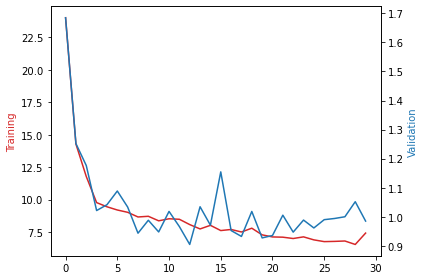

In [74]:
def plot_train_val(train, valid):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_ylabel('Training', color=color)
    ax1.plot(train, color=color)
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Validation', color=color)
    ax2.plot(valid, color=color)
    fig.tight_layout()
    
plot_train_val(train_history, valid_history)

<div class = "alert alert-warning">

La training_error diminue progressivement alors que la generalization_error (validation) diminue puis réaugmente : on est en train d'**overfitter** quand on fait 30 époques...
- il faut régulariser : empêcher l'overfitting

As we see in the above plots, the validation accuracy might fluctuate or increase while minimizing the training loss. If the validation loss increases too much while the training loss decreases, we consider this **overfitting** to the training data. 

## Early Stopping

<div class = "alert alert-warning">
    
**Première méthode de régularisation : early stopping**
    
    
Si la generalisation_error augmente et reste au dessus que le meilleur score pendant plus que la patience alors on arrête prématurément les boucles d'apprentissage sur les époques

One of the ways to overcome overfitting is early stopping. We'll stop the training early based on increases to the validation loss. If the validation loss is higher than the current lowest validation lost for a certain number of epochs we'll stop the training. The number of epochs we wait is known as the `patience`.

In [75]:
class EarlyStopping:
    
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.delta = delta
        self.early_stop = False

    def step(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            print('EarlyStopping counter: %d / %d' % (self.counter, self.patience))
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [76]:
def train(net, earlystopping=True):
    optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
    train_history = []
    valid_history = []
    estop = EarlyStopping(patience=2)
    for epoch in range(30):
        train_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        valid_loss = validation(net)
        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print('Epoch %02d: train loss %0.5f, validation loss %0.5f' % (epoch, train_loss, valid_loss))
        estop.step(valid_loss)
        if earlystopping and estop.early_stop:
            break
    return train_history, valid_history

Epoch 00: train loss 22.92629, validation loss 1.71808
Epoch 01: train loss 14.95319, validation loss 1.32077
Epoch 02: train loss 11.36183, validation loss 1.07675
Epoch 03: train loss 10.02838, validation loss 1.03335
Epoch 04: train loss 9.38848, validation loss 0.95108
Epoch 05: train loss 8.81992, validation loss 0.95157
EarlyStopping counter: 1 / 2
Epoch 06: train loss 8.81349, validation loss 0.93030
Epoch 07: train loss 8.61268, validation loss 0.99570
EarlyStopping counter: 1 / 2
Epoch 08: train loss 8.52164, validation loss 0.91026
Epoch 09: train loss 8.75067, validation loss 1.02768
EarlyStopping counter: 1 / 2
Epoch 10: train loss 8.57571, validation loss 0.98413
EarlyStopping counter: 2 / 2


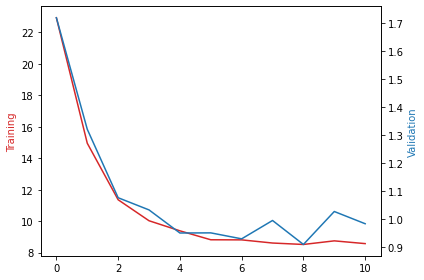

In [77]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=512, shuffle=True, num_workers=2)
criterion = nn.CrossEntropyLoss()
net = SimpleNet()
train_history, valid_history = train(net)
plot_train_val(train_history, valid_history)

<div class = "alert alert-warning">

**Autre méthode de régularisation : modification de la loss pour prendre en compte les valeurs des paramètres**     
    
On peut aussi ajouter la somme des normes L1 ou L2 paramètres à la loss pour éviter l'overfitting en limitant le nombre/valeur des variables pertinentes

## Dropout

<div class = "alert alert-warning">

**Une autre méthode de régularisation : dropout**
    
    
A chaque époque, il y aura certains neurones qu'on va désactiver pour casser la symétrie. On va focaliser l'apprentissage sur certains neurones pendant une époque 
    
Certain neurones sont donc moins expressifs que d'autres, ce qui évite l'overfitting

Another way to prevent overfitting is by not training certain weights at a given update step, leading to greater generalization over the whole network. The classic formulation of this is dropout, where neuron activations are "dropped out" (set to zero) with probability *p*. This is as if, for a given update, only a subnetwork is trained: 
<img src="img/dropout_network.png">
Srivastava, Nitish, et al. "Dropout: a simple way to prevent neural networks from overfitting." The journal of machine learning research 15.1 (2014): 1929-1958.

Dropout has shown improvements for overfitting with many different architectures, although the specifics of where to use dropout in a network and what dropout rates to use ($p$) are still not well-defined.

<img src="img/dropout_results.png">

Torch uses spatial dropout, which is described here: https://arxiv.org/pdf/1411.4280.pdf

<div class="alert alert-success">
Exercise 7: Create a network that includes at least one dropout layer. How does Dropout influence the training?
</div>

Epoch 00: train loss 23.01870, validation loss 1.75321
Epoch 01: train loss 13.77335, validation loss 1.28204
Epoch 02: train loss 10.98366, validation loss 1.14237
Epoch 03: train loss 10.67988, validation loss 1.10355
Epoch 04: train loss 10.40234, validation loss 1.08403
Epoch 05: train loss 9.82203, validation loss 1.10839
EarlyStopping counter: 1 / 2
Epoch 06: train loss 9.56390, validation loss 1.08169
Epoch 07: train loss 9.36678, validation loss 1.05469
Epoch 08: train loss 9.70749, validation loss 0.94455
Epoch 09: train loss 9.13321, validation loss 1.07058
EarlyStopping counter: 1 / 2
Epoch 10: train loss 9.17424, validation loss 1.04859
EarlyStopping counter: 2 / 2
Epoch 11: train loss 8.68355, validation loss 1.00521
EarlyStopping counter: 3 / 2
Epoch 12: train loss 8.76136, validation loss 1.05664
EarlyStopping counter: 4 / 2
Epoch 13: train loss 8.68887, validation loss 1.18488
EarlyStopping counter: 5 / 2
Epoch 14: train loss 8.97409, validation loss 1.17252
EarlyStoppi

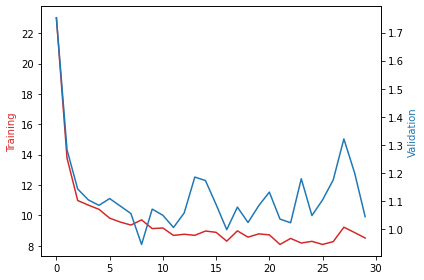

In [79]:
# %load solutions/ex7.py
class DropoutNet(nn.Module):
    
    def __init__(self):
        super(DropoutNet, self).__init__()
        self.fc1 = nn.Linear(784,600)
        self.drop = nn.Dropout(0.25) #pendant une époque, on prend aléatoirement 1/4 des neurones de chaque couche et on ne va pas leur appliquer de gradient (leur poids ne va pas changer)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 10)
        
    def forward(self, x):
        x = x.view(-1,784)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        x = self.fc3(x)
        return x


net = DropoutNet()
train_history, valid_history = train(net, earlystopping=False)
plot_train_val(train_history, valid_history)


<div class = "alert alert-warning">

**Autre solution de régularisation : data augmentation**

le problème de l'overfitting = les données initiales ne sont pas représentatives de l'univers des données possibles
- une solution peut donc d'être de générer plus de données pour que l'ensemble de départ soit plus représentatif 

# <a id="sec7">7. Improving Optimization</a>

<div class = "alert alert-warning">

On peut améliorer la méthode d'optimisation (au lieu d'utiliser SGD)
- Adam : adaptive moment optimisation

Just to review, training a neural network is a function of maximizing some objective function $Q$; it is a process of optimization. $Q$ can be, for example, a MSE Loss function:
$$
Q_i(\theta) = (X(\theta, i) - h_i)^2\\
Q(\theta) = \frac{1}{n}\sum_{i=1}^n Q_i(\theta)
$$
So far, we've been using SGD (Stochastic Gradient Descent) for this optimization:

In [ ]:
net = SimpleNet()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

In other words, we're doing our weight ($\theta$) update according to the following:

$$
\Delta \theta^{(t+1)} \leftarrow \alpha\Delta \theta^{(t)}-\eta\nabla Q_i (\theta^{(t)})\\
\theta^{(t+1)} \leftarrow \theta^{(t)} + \Delta \theta^{(t+1)}
$$

These two hyperparameters, learning rate ($\alpha$) and momentum ($\eta$), change how the neural network minimizes the loss and can have drastic impact on the learning.

<img src="img/sgd.gif" width="80%">

A popular optimizer is the Adaptive Moment Estimation ([Adam](https://arxiv.org/pdf/1412.6980.pdf)) optimizer. This optimizer takes into account the recent weight changes when making a new update:

$$
m_\theta^{(t+1)} \leftarrow \beta_1 m_\theta^{(t)} + (1-\beta_1) \nabla Q_i(\theta^{(t)})\\
v_\theta^{(t+1)} \leftarrow \beta_2 v_\theta^{(t)} + (1-\beta_2)(\nabla Q_i(\theta^{(t)}))^2\\
\hat{m}_\theta = \frac{m_\theta^{(t+1)}}{1-\beta_1^t}\\
\hat{v}_\theta = \frac{v_\theta^{(t+1)}}{1-\beta_2^t}\\
\theta^{(t+1)} \leftarrow \theta^{(t)} - \eta\frac{\hat{m}_\theta}{\sqrt{\hat{v}_\theta}+\epsilon}
$$

While this optimizer can often perform better than SGD, it introduces new hyperparameter choices: $\beta_1$ (update to $\hat{m}$), $\beta_2$ (update to $\hat{v}$), and $\epsilon$ (ratio between $\hat{m}$ and $\hat{v}$). Let's see the defaults for torch:

In [ ]:
help(torch.optim.Adam)

As with SGD, the choice of hyperparameters heavily affects the training.

<img src="img/adam.gif" width="80%">

<div class="alert alert-success">
Exercise 8: change the optimizer in our training method to Adam and train one of the networks we've defined.
</div>

Epoch 00: train loss 21.36321, validation loss 1.38307
Epoch 01: train loss 12.41556, validation loss 1.17936
Epoch 02: train loss 10.96232, validation loss 1.10681
Epoch 03: train loss 10.27849, validation loss 1.03685
Epoch 04: train loss 9.68175, validation loss 1.00647
Epoch 05: train loss 9.40752, validation loss 1.00247
Epoch 06: train loss 9.15775, validation loss 1.02629
Epoch 07: train loss 8.82164, validation loss 0.95567
Epoch 08: train loss 8.59916, validation loss 0.94833
Epoch 09: train loss 8.51239, validation loss 0.92632
Epoch 10: train loss 8.28584, validation loss 0.91615
Epoch 11: train loss 8.03392, validation loss 0.93332
Epoch 12: train loss 7.99953, validation loss 0.89347
Epoch 13: train loss 7.87035, validation loss 0.90397
Epoch 14: train loss 7.91074, validation loss 0.91843
Epoch 15: train loss 7.74464, validation loss 0.89382
Epoch 16: train loss 7.47302, validation loss 0.89148
Epoch 17: train loss 7.50823, validation loss 0.88771
Epoch 18: train loss 7.4

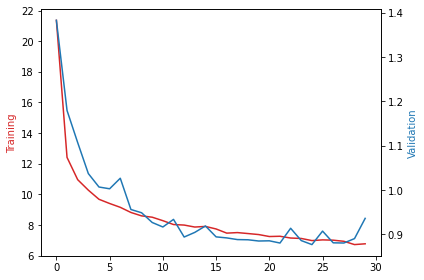

In [81]:
# %load solutions/ex8.py
def train(net):
    optimizer = torch.optim.Adam(net.parameters())
    train_history = []
    valid_history = []
    for epoch in range(30):
        train_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        valid_loss = validation(net)
        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print('Epoch %02d: train loss %0.5f, validation loss %0.5f' % (epoch, train_loss, valid_loss))
    return train_history, valid_history

trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=512, shuffle=True, num_workers=2)
criterion = nn.CrossEntropyLoss()
net = SimpleNet()
train_history, valid_history = train(net)
plot_train_val(train_history, valid_history)


In this notebook, our training code has gotten very long. Thankfully, `torch` comes with a high-level library [`ignite`](https://pytorch.org/ignite/) which allows us to easily train and including things like EarlyStopping and logging. That's out of the scope of the material for today, but please look at [this notebook](https://github.com/pytorch/ignite/blob/master/examples/notebooks/FashionMNIST.ipynb) before next class.

Some other libraries like `ignite`:
+ https://docs.fast.ai/
+ https://github.com/skorch-dev/skorch
+ https://github.com/williamFalcon/pytorch-lightning

<div class = "alert alert-warning">

Alternative à torch : ignite (torch rsete très utilisé et suffisant)

# 8. Neural Architectures

<div class = "alert alert-warning">

Architecture du réseau : 
- choix du nombre de couches et de neurones par couche
- choix de l'optimiseur
- choix des hyperparamètres

On sait apprendre les poids à architecture figée mais on ne sait pas faire apprendre l'architecture du réseau de neurone de façon automatique : 
- il reste une grande part d'artisanat pour choisir l'architecture du réseau

So far, we've seen a number of different layer types, (Fully-connected, Convolutional, MaxPooling) activations (Sigmoid, ReLU, Softmax), and additional components like Dropout, which we include as a sort of "layer" in our
architecture. These and more are all the base components of neural networks which can be mixed and matched to create different neural architectures. Let's work our way through some historical milestones.

## 8.1 LeNet

<img src="img/lenet.png">

LeNet is often considered the **first modern deep convolutional neural network, was benchmarked on MNIST**.
    
*LeCun, Yann, et al. "Gradient-based learning applied to document recognition." Proceedings of the IEEE 86.11 (1998): 2278-2324.*

## 8.2 AlexNet

<img src="img/alexnet.png">

AlexNet became well-known due to its **performance on the ImageNet classification
benchmark**.

*Krizhevsky, Alex, Ilya Sutskever, and Geoffrey E. Hinton. "Imagenet classification with deep convolutional neural networks." Advances in neural information processing systems. 2012.*
    
https://github.com/pytorch/vision/blob/master/torchvision/models/alexnet.py

## 8.3 VGG (16)

<img src="img/vgg16.png">

The ImageNet benchmark and related competition continued to be a source of new
architectures in the 2010s with the VGG family of architectures also gaining
recognition for their performance. The impressive depth of these networks was
novel and built on advances in weight optimization.

**Profondeur 16, almost fully-convolutional, référence métier aujourd'hui (réapprentissage des poids ou réapprentissage seulement de la sortie)**
    
*Simonyan, Karen, and Andrew Zisserman. "Very deep convolutional networks for large-scale image recognition." ICLR, 2015.*

## 8.4 InceptionNet

<img src="img/inception.png">

While VGG went deeper, other networks started proposing parallel blocks of small
convolutions which allowed for better dimensionality reduction. The InceptionNet
is composed of these so-called "inception blocks".

**Convolution à différentes échelles qu'on empile, équivalent de 50 couches**

*Szegedy, Christian, et al. "Rethinking the inception architecture for computer vision." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.*

https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py

## 8.5 GoogLeNet

<img src="img/googlenet.png">

GoogLeNet, named after LeNet, combined advances like inception blocks and the
deeper VGG architectures, beating VGG in 2014 by 7.32% to 6.67% on the ImageNet
benchmark.

**Combinaison de VGG et InceptionNet qui est le meilleur en ImageNet benchmark**

*Szegedy, Christian, et al. "Going deeper with convolutions." Proceedings of the IEEE conference on computer vision and pattern recognition. 2015.*

https://github.com/pytorch/vision/blob/master/torchvision/models/googlenet.py

## 8.6 ResNet

<img src="img/resnet.png">
<img src="img/resnet_vgg.png">

Residual Networks use skip or shortcut connections, unweighted identity
functions, to pass information from one part of the newtork to a later part.
These so-called "residual blocks" allow for independent functions to be learned
by a part of the network without needing to also pass a transformation of the
data down-stream.

**Jusqu'à profondeur 100, on peut sauter une couche**

*He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.*

https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

## 8.7 Differentiable Architecture Search

<img src="img/darts.png">

Neural Architecture Search, the automatic research for architectures, is growing
as a research field. Better networks than ResNet or VGG have been found with
these method for the CIFAR and ImageNet benchmarks.

**Descente de gradient sur l'architecture du réseau pour trouver la meilleure architecture**

*Liu, Hanxiao, Karen Simonyan, and Yiming Yang. "DARTS: Differentiable
Architecture Search." International Conference on Learning*
Representations. 2018. [pdf](https://arxiv.org/pdf/1806.09055.pdf)

## 8.8 NSGA-Net

<img src="img/nsganet.png" width="50%" height=auto>

Evolutionary algorithms are one popular approach to neural architecture search,
such as NSGA-Net. Important objectives in NAS are to increase model accuracy
while reducing complexity, measured by training time and number of parameters.

**Recherche d'architecture à partir de stratégie évolutionnaire : NSGA-Net (nondominated sort GA used on nets)**

*Lu, Zhichao, et al. "Nsga-net: neural architecture search using multi-objective
genetic algorithm." Proceedings of the Genetic and Evolutionary Computation*
Conference. 2019. [code](https://github.com/ianwhale/nsga-net)

<div class="alert alert-success">
Exercise 9 (at home): Look at one of the torchvision implementations of models and the reference paper to understand how the torch version is implemented. Train a network of your choice on CIFAR10 using ignite.
</div>

<div class = "alert alert-warning">

Chercher dans torch les architectures déjà implémentées (ex: VGG16) pour voir à quoi ça ressemble un réseau de neurone manipulé dans une équipe de production, R&D, etc.

Les applications sont très diverses : 
- traitement d'image
- traitement de langage naturel 
- traitement de données issues de capteurs, etc.

En cas d'oubli : *60 minutes blitz* in pythorch tutorial